In [92]:
import os
import sys

!pip install opencv-python
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

You should consider upgrading via the 'C:\Users\sarat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [93]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Загрузка и предобработка данных

Для загрузки и обработки данных мы испрользовали библиотеку OpenCV. Для обработки использовался алгоритм [Histograms Equalization](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html) что уменьшает весь картинок переводя из RGB в моно, а также выравнивает распределение цветов на изображении.

In [94]:
def fill_df(df, path, files, covid_test):
    for f in files:
        p = path + f
        img = cv.imread(p)
        df = df.append({'image':img, 'path':p, 'covid':covid_test}, ignore_index=True)
    return df

In [95]:
def fill_and_compute_df(df, path, files, covid_test):
    for f in files:
        p = path + f
        img = cv.imread(p)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        equ = cv.equalizeHist(img)
        df = df.append({'image':equ, 'path':p, 'covid':covid_test}, ignore_index=True)
    return df

In [96]:
curr_path = os.path.abspath(os.getcwd())
cov_path  = curr_path[:-22] + 'COVID/'
norm_path = curr_path[:-22] + 'NORMAL/'

In [97]:
cov_files  = os.listdir(cov_path)
norm_files = os.listdir(norm_path)

In [98]:
df = pd.DataFrame(columns = ['image', 'path', 'covid'])

In [99]:
df = fill_and_compute_df(df, cov_path, cov_files, 1)
df = fill_and_compute_df(df, norm_path, norm_files, 0)

In [100]:
df.head()

,image,path,covid
0,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",F:\iad\COVID/covid_0.jpg,1
1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,...",F:\iad\COVID/covid_1.jpg,1
2,"[[14, 12, 12, 8, 12, 12, 8, 8, 5, 8, 12, 12, 1...",F:\iad\COVID/covid_10.jpg,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",F:\iad\COVID/covid_100.jpg,1
4,"[[25, 25, 25, 25, 25, 24, 24, 24, 24, 24, 24, ...",F:\iad\COVID/covid_101.jpg,1


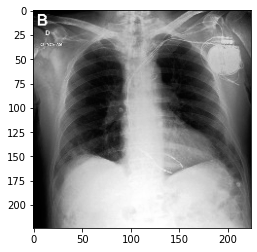

In [101]:
plt.imshow(df['image'][1], cmap='gray')

In [102]:
df.describe()

,image,path,covid
count,324,324,324
unique,324,324,2
top,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",F:\iad\COVID/covid_0.jpg,1
freq,1,1,162


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   324 non-null    object
 1   path    324 non-null    object
 2   covid   324 non-null    object
dtypes: object(3)
memory usage: 7.7+ KB


# Разбиение и работа с моделями

In [104]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [105]:
def train_model(model, epochs, criterion, optimizer, X_train, Y_train, X_test, Y_test):
    losses = []

    for i in range(epochs):
        i += 1
        Y_pred = model.forward(X_train)
        loss = criterion(Y_pred, Y_train)
        losses.append(loss)
        acc = test_model(model_2, X_test, Y_test, 0)
        print(f'epoch: {i:2}  loss: {loss.item():10.8f} acc: {acc}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

In [106]:
def test_model(model, X_test, Y_test, show):
    counter = 0
    y_test_len = len(Y_test)

    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    res = 100*counter/y_test_len
    if show:
        print(f'{counter} out of {y_test_len} = {res}% right')
    else:
        return res

In [107]:
# так как работа связана с медициной то используем confusion_matrix
def test_res_model(model, X_test, Y_test):
    T = []
    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            res = y_val.argmax().item()
            T.append(res)
    return confusion_matrix(T, Y_test)

In [108]:
data_copy = df.copy()

In [109]:
data_split = data_copy.copy()

y = data_split['covid'].values
x = data_split['image'].values

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

In [111]:
X_train = [np.hstack(image).astype(np.float32) for image in X_train]

In [112]:
X_test = [np.hstack(image).astype(np.float32) for image in X_test]

In [113]:
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
Y_train_tensor = torch.tensor(list(Y_train))
Y_test_tensor = torch.tensor(list(Y_test))

### Работа с моделями

In [114]:
model_2 = nn.Sequential(
    nn.Linear(224 * 224, 224),
    nn.ReLU(),
    nn.Linear(224, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),    
    nn.Linear(4, 2),
    nn.Sigmoid())

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [116]:
epochs = 3
model_2  = train_model(model_2, epochs, criterion, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

epoch:  1  loss: 0.72652626 acc: 48.97959183673469
epoch:  2  loss: 0.69314730 acc: 48.97959183673469
epoch:  3  loss: 0.69314730 acc: 48.97959183673469


In [118]:
test_res_model(model_2, X_test_tensor, Y_test_tensor)

array([[48, 50],
       [ 0,  0]], dtype=int64)

In [83]:
input_size = 224 * 224
hidden_sizes = [283, 43, 32, 5, 2]
output_size = 2
print(hidden_sizes)

[283, 43, 32, 5, 2]


In [88]:
model3 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[4], output_size))

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

In [90]:
epochs = 10
model3_ = train_model(model3, epochs, criterion, optimizer, X_train_tensor, Y_train_tensor)

torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  1  loss: 0.72568846
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  2  loss: 288.47549438
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  3  loss: 2.95389080
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  4  loss: 0.73329192
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  5  loss: 0.73390949
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  6  loss: 0.73386192
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  7  loss: 0.73335350
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  8  loss: 0.73251337
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch:  9  loss: 0.73143214
torch.Size([226, 50176])
torch.Size([226, 2])
torch.Size([226])
epoch: 10  loss: 0.73017693


In [91]:
test_model(model3_, X_test_tensor, Y_test_tensor)

48 out of 98 = 48.98% right
